In [ ]:
import numpy
import sklearn.svm
from sklearn.linear_model import LogisticRegression
import numpy
import matplotlib.pyplot as plt
import random
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def reduce_features(solution, features):
    selected_elements_indices = numpy.where(solution == 1)[0]
    reduced_features = features[:, selected_elements_indices]
    return reduced_features

def classification_accuracy(labels, predictions):
    correct = numpy.where(labels == predictions)[0]
    accuracy = correct.shape[0]/labels.shape[0]
    return accuracy*100

CLASSIFIER MODELS

In [ ]:
def cal_pop_fitness(pop, features, labels, train_indices, test_indices):
    accuracies = numpy.zeros(pop.shape[0])
    idx = 0

    for curr_solution in pop:
        reduced_features = reduce_features(curr_solution, features)
        train_data = reduced_features[train_indices, :]
        test_data = reduced_features[test_indices, :]

        train_labels = labels[train_indices]
        test_labels = labels[test_indices]

        #SVM CLASSIFIER
        SV_classifier = sklearn.svm.SVC(gamma='scale')
        SV_classifier.fit(X=train_data, y=train_labels)
        predictions = SV_classifier.predict(test_data)
        
        #LOGISTIC REGRESSION CLASSIFIER
        '''
        clf = LogisticRegression()
        clf.fit(X=train_data, y=train_labels)
        predictions = clf.predict(test_data)
        '''

        accuracies[idx] = classification_accuracy(test_labels, predictions)
        idx = idx + 1
    return accuracies

PARENT SELECTION

In [ ]:
#rank selection
def rank_selection_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999
    return parents

#tournament selection
def tournament_selection_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    k=numpy.uint8(pop.shape[0]/2)
    for parent_num in range(num_parents):
      tournament = [random.randint(0,len(fitness)-1) for i in range(k)]
      fitnesses = [fitness[tournament[i]] for i in range(k)]
      parents[parent_num, :]=pop[tournament[fitnesses.index(max(fitnesses))]]
    return parents
  
#roulette wheel selection
def roulette_wheel_selection(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = numpy.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
      randomList = random.choices(pop, weights=fitness, k=1) 
      parents[parent_num, :]=randomList[0]
    return parents

CROSSOVER

In [ ]:
#uniform point crossover
def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        #probability matrix
        p=np.random.rand(offspring_size[1])

        for i in range(offspring_size[1]):
        # The new offspring will have its ith genes taken from the first parent if probability<0.5 and from the second parent if the probablility>=0.5.
          if p[i]<0.5:
            offspring[k,i:i+1] = parents[parent1_idx, i:i+1]
          else:
            offspring[k,i:i+1] = parents[parent2_idx, i:i+1]
    return offspring

#single point crossover
def single_crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The point at which crossover takes place between two parents
    crossover_point = numpy.random.randint(low=0, high=offspring_size[1])

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

#two point crossover
def two_point_crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
    # The points at which crossover takes place between two parents
    crossover_point_1 = numpy.random.randint(low=0, high=offspring_size[1])
    crossover_point_2 = numpy.random.randint(low=crossover_point_1+1, high=offspring_size[1])

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the second parent.
        offspring[k, 0:crossover_point_1] = parents[parent2_idx, 0:crossover_point_1]
        # The new offspring will have its second half of its genes taken from the first parent.
        offspring[k, crossover_point_1:crossover_point_2] = parents[parent1_idx, crossover_point_1:crossover_point_2]
        # The new offspring will have its third half of its genes taken from the second parent.
        offspring[k, crossover_point_2:] = parents[parent2_idx, crossover_point_2:]
    return offspring

MUTATION

In [ ]:
#bit flip mutation
def bit_flip_mutation(offspring_crossover, num_mutations):
    mutation_idx = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        offspring_crossover[idx, mutation_idx] = 1 - offspring_crossover[idx, mutation_idx]
    return offspring_crossover

#swap mutation
def swap_mutation(offspring_crossover, num_mutations):
    mutation_idx_1 = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    mutation_idx_2 = numpy.random.randint(low=0, high=offspring_crossover.shape[1], size=num_mutations)
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
        # The random value to be added to the gene.
        temp=offspring_crossover[idx, mutation_idx_1]
        offspring_crossover[idx, mutation_idx_1] = offspring_crossover[idx, mutation_idx_2]
        offspring_crossover[idx, mutation_idx_2] = temp
    return offspring_crossover

#inverse mutation
def mutation(offspring_crossover, num_mutations):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(offspring_crossover.shape[0]):
      val=numpy.random.randint(low=0, high=offspring_crossover.shape[1]-num_mutations-1)
      temp=offspring_crossover[idx]
      np.flip(temp)
      for j in range(val,val+num_mutations):
        offspring_crossover[idx,j:j+1]=temp[j]
    return offspring_crossover

In [ ]:
def normalize(dataset):
    dataNorm=((dataset-dataset.mean())/(dataset.std()))
    dataNorm["Sad"]=dataset["Sad"]
    return dataNorm

In [ ]:
df = pd.read_csv('gdrive/My Drive/Final.csv')
df=df.drop(['face'],1)
df=df.drop(['Unnamed: 0'],1)
df=df.drop(['Unnamed: 0.1'],1)
df=df.drop(['Unnamed: 0.1.1'],1)
df = df.sample(frac = 1) 
print(df)
  
df = normalize(df)

x = np.array(df.drop(['Sad'],1))
y = np.array(df['Sad'])

data_inputs = x
data_outputs = y

     Sad  confidence  gaze_0_x  gaze_0_y  ...  AU25_c  AU26_c  AU28_c  AU45_c
91     0       0.975  0.125494  0.033885  ...     0.0     0.0     0.0     0.0
69     0       0.975  0.103006  0.137374  ...     1.0     1.0     0.0     0.0
44     0       0.975  0.090385  0.188348  ...     1.0     1.0     0.0     0.0
162    1       0.975 -0.014247  0.205987  ...     0.0     1.0     0.0     1.0
57     0       0.925  0.300676 -0.042798  ...     1.0     1.0     0.0     0.0
..   ...         ...       ...       ...  ...     ...     ...     ...     ...
83     0       0.975  0.112519  0.245022  ...     1.0     1.0     0.0     0.0
136    1       0.875  0.039654 -0.102518  ...     0.0     0.0     0.0     0.0
129    1       0.975  0.075256  0.087103  ...     0.0     0.0     0.0     0.0
89     0       0.925  0.044115  0.029234  ...     1.0     1.0     0.0     1.0
185    1       0.975  0.234058  0.142601  ...     0.0     0.0     0.0     1.0

[205 rows x 711 columns]


In [ ]:
num_samples = data_inputs.shape[0]
num_feature_elements = data_inputs.shape[1]

train_indices = numpy.arange(0,num_samples*0.7*(0.7), 1,int)
val_indices = numpy.arange(num_samples*0.7*(0.7)+1,num_samples*0.7, 1,int)
test_indices_1 = numpy.arange((num_samples*0.7)+1, num_samples*0.7+num_samples*0.3*0.7, 1,int)
test_indices_2 = numpy.arange(num_samples*0.7+num_samples*0.7*0.3+1, num_samples, 1,int)

In [ ]:
#Genetic algorithm parameters:
sol_per_pop = 20 # Population size.
num_parents_mating = 10 # Number of parents inside the mating pool.
num_mutations = 70 # Number of elements to mutate.
num_generations = 1000

# Defining the population shape.
pop_shape = (sol_per_pop, num_feature_elements)

# Creating the initial population.
new_population = numpy.random.randint(low=0, high=2, size=pop_shape)
print(new_population.shape)
best_population=new_population

best_outputs = []

(20, 711)


In [ ]:
for generation in range(num_generations):
    print("Generation : ", generation)
    # Measuring the fitness of each chromosome in the population.
    fitness = cal_pop_fitness(new_population, data_inputs, data_outputs, train_indices, val_indices)
    print("Fitness")
    print(fitness)
    print(numpy.max(fitness))
    if generation>1 and numpy.max(fitness)>=best_outputs[-1]:
      best_population=new_population

    best_outputs.append(numpy.max(fitness))
    # The best result in the current iteration.
    print("Best fitness so far : ", best_outputs[-1])

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_shape[0]-parents.shape[0], num_feature_elements))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    offspring_mutation = mutation(offspring_crossover, num_mutations=num_mutations)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

Generation :  0
Fitness
[72.09302326 81.39534884 86.04651163 79.06976744 81.39534884 81.39534884
 79.06976744 79.06976744 79.06976744 74.41860465 79.06976744 76.74418605
 76.74418605 81.39534884 79.06976744 86.04651163 83.72093023 81.39534884
 79.06976744 79.06976744]
86.04651162790698
Best fitness so far :  86.04651162790698
Parents
[[1. 1. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 1. 1. 1.]]
Crossover
[[1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 1. 0. 1.]]
Mutation
[[1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 1. 0. 1.]]
Generation :  1
Fitness
[86.04651163 81.39534884 79.06976744 76.74418605 79.06976744 81.39534884
 83.72093023 86.04651163 79.06976744 86.04651163 83.72093023 76.74418605
 81.395

In [ ]:
# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness = cal_pop_fitness(best_population, data_inputs, data_outputs, train_indices, val_indices)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = numpy.where(fitness == numpy.max(fitness))[0]
best_match_idx = best_match_idx[0]

best_solution = best_population[best_match_idx, :]
best_solution_indices = numpy.where(best_solution == 1)[0]
best_solution_num_elements = best_solution_indices.shape[0]
best_solution_fitness = fitness[best_match_idx]

print("best_solution : ", best_solution)
print("Selected indices : ", best_solution_indices)
print("Number of selected features : ", best_solution_num_elements)
print("Best solution fitness(Training accuracy) : ", best_solution_fitness)

best_solution :  [1 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1
 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0
 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1
 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1
 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0
 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0
 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1
 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1
 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1
 0 0 1 0

In [ ]:
features=df.columns
Dict = {}
for i in range(0,best_solution_num_elements):
  Dict[i]=features[best_solution_indices[i]]
import operator
sorted_x = sorted(Dict.items(), key=operator.itemgetter(1),reverse=True)
print("Printing features in the best feature subset")
x=0
for i in sorted_x:
  print(x,":",i[1])
  x=x+1

Printing features in the best feature subset
0 : y_8
1 : y_7
2 : y_66
3 : y_63
4 : y_62
5 : y_61
6 : y_60
7 : y_6
8 : y_58
9 : y_54
10 : y_53
11 : y_51
12 : y_5
13 : y_45
14 : y_43
15 : y_42
16 : y_41
17 : y_39
18 : y_36
19 : y_35
20 : y_34
21 : y_30
22 : y_3
23 : y_29
24 : y_28
25 : y_26
26 : y_25
27 : y_23
28 : y_21
29 : y_20
30 : y_19
31 : y_18
32 : y_17
33 : y_15
34 : y_14
35 : y_11
36 : y_10
37 : y_0
38 : x_8
39 : x_64
40 : x_63
41 : x_62
42 : x_60
43 : x_56
44 : x_54
45 : x_53
46 : x_51
47 : x_5
48 : x_48
49 : x_46
50 : x_45
51 : x_44
52 : x_43
53 : x_40
54 : x_39
55 : x_37
56 : x_36
57 : x_32
58 : x_3
59 : x_29
60 : x_28
61 : x_27
62 : x_26
63 : x_23
64 : x_22
65 : x_20
66 : x_18
67 : x_17
68 : x_15
69 : x_14
70 : x_13
71 : x_11
72 : pose_Rx
73 : p_tx
74 : p_rz
75 : p_ry
76 : p_5
77 : p_32
78 : p_3
79 : p_29
80 : p_27
81 : p_26
82 : p_25
83 : p_24
84 : p_22
85 : p_20
86 : p_2
87 : p_18
88 : p_17
89 : p_1
90 : p_0
91 : gaze_1_z
92 : gaze_0_y
93 : eye_lmk_y_8
94 : eye_lmk_y_7
95 :

In [ ]:
print(best_outputs)

[86.04651162790698, 86.04651162790698, 86.04651162790698, 86.04651162790698, 86.04651162790698, 86.04651162790698, 83.72093023255815, 83.72093023255815, 83.72093023255815, 81.3953488372093, 81.3953488372093, 83.72093023255815, 81.3953488372093, 81.3953488372093, 83.72093023255815, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093, 81.3953488372093

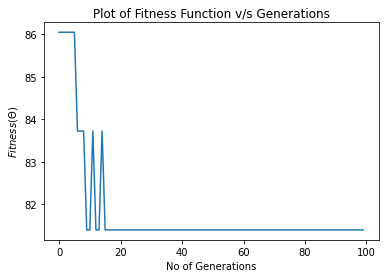

In [ ]:
plt.plot(best_outputs)
plt.xlabel("No of Generations")
plt.ylabel("$Fitness(\Theta)$")
plt.title("Plot of Fitness Function v/s Generations")
plt.show()

In [ ]:
fitness = cal_pop_fitness(best_population, data_inputs, data_outputs, test_indices_1, test_indices_2)
testacc=numpy.max(fitness)
print("Testing Accuracy of the best solution is : ", testacc)

Testing Accuracy of the best solution is :  55.55555555555556
